In [8]:
import pysam
import numpy as np
import pandas as pd

# Allele counts
from collections import Counter

# Matrix sorting
#from scipy.spatial.distance import pdist, squareform
#from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# Plots
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable

In [9]:
# === PARAMETERS ===
vcf_path = "/mnt/urbe2/disk3/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.bam.bcftools_mpileup.bcf"
fasta_path = "/mnt/urbe2/disk3/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/reference.fa"
bam_path = "/mnt/urbe2/disk3/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.bam"
fastq_path = "/mnt/urbe2/disk3/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/READS/PAG10697.PAF32118a.validated.pass.fastq.gz"
#output_path = "./haplotype_kmers.txt"
k = 15                     # k-mer size

In [10]:
def extract_biallelic_snps(bcf_path, ref, start, end):
    # Open BCF file
    bcf = pysam.VariantFile(bcf_path)

    records = []
    is_biallelic = lambda alleles: len(set(alleles)) == 2
    is_snp = lambda alleles: all(al != '*' for al in alleles)
    
    # Iterate over variants in specified region
    for rec in bcf.fetch(ref, start, end):
        # Filter biallelic SNPs
        alleles = rec.alleles
        if is_biallelic(alleles) and is_snp(alleles):

            try:
                ad = rec.samples[0].get('AD')
                af = np.max(ad)/np.sum(ad)
            except:
                af = None
            
            records.append({
                "POS": rec.pos,
                "REF": rec.ref,
                "ALT": rec.alts[0],
                "AF": af,
            })

    bcf.close()
    return pd.DataFrame(records)



def extract_bases_at_positions(bam_path, ref_name, positions):
    bam = pysam.AlignmentFile(bam_path, "rb")
    results = []

    for pos in positions:
        pos -= 1
        for pileup_column in bam.pileup(ref_name, pos, pos+1, truncate=True, stepper='all', ignore_overlaps=False):
            if pileup_column.pos != pos:
                continue  # safety check
            for pileup_read in pileup_column.pileups:
                if pileup_read.is_del or pileup_read.is_refskip:
                    continue  # skip deletions or reference skips

                base = pileup_read.alignment.query_sequence[pileup_read.query_position]
                read_name = pileup_read.alignment.query_name
                results.append({
                    "read_name": read_name,
                    "pos": pos + 1,  # convert to 1-based
                    "base": base
                })

    bam.close()

    return pd.DataFrame(results)

def reconstruct_haplotypes(results, positions):
    reads = results.groupby(by='read_name')#.agg({'read_name':'first', 'pos':list, 'base':list})
    
    per_read_haplotype = {}
    
    for i, rp in reads:
        #display(rp)
        read_name = rp.iloc[0]['read_name']
        pos_matrix = [None for _ in positions]
        for i, pos in enumerate(positions):
            try:
                local_base = rp.loc[rp['pos'] == pos]['base'].iloc[0]
                pos_matrix[i] = local_base
            except:
                continue
    
        per_read_haplotype[read_name] = pos_matrix
        #break

    return per_read_haplotype

### Plot read haplotypes and find repaired reads

In [11]:
def convert_matrix(per_read_haplotype):
    base_to_int = {None: np.nan, 'A': 1, 'T': 2, 'C': 3, 'G': 4}
    mat = []
    for hap in per_read_haplotype.values():
        mat.append(list(hap))
    ### Convert matrix of ATCG to numbers
    numeric_array = np.array([[base_to_int[base] for base in row] for row in mat], dtype='float')
    return numeric_array

def sort_matrix(numeric_array, max_nan=10, empty_first=True, start_reverse=False, sort_agglo=False):
    
    # Count NaNs per row
    length_row = len(numeric_array[0])
    nan_counts = np.isnan(numeric_array).sum(axis=1)
    #not_nan_counts = np.array([length_row-nan_counts[c] for c in nan_counts])
    #print(not_nan_counts)
    # Keep rows with <= MIN SNPS SPANNED NaNs
    filtered_array = numeric_array[nan_counts <= max_nan]

    cumsum_matrix = np.cumsum(filtered_array, axis=1)

    """
    # Change NaN to inf
    if empty_first:
        inf_mat = np.where(np.isnan(filtered_array), -np.inf, filtered_array)
    else:
        inf_mat = np.where(np.isnan(filtered_array), np.inf, filtered_array)
    """
    
    # Sort by row similarity
    if start_reverse:
        cumsum_matrix = np.fliplr(cumsum_matrix)

    sort_keys = [cumsum_matrix[:, i] for i in reversed(range(cumsum_matrix.shape[1]))]
    idx = np.lexsort(sort_keys)
    sorted_mat = filtered_array[idx]

    if sort_agglo:
        rows = np.array([[-1 if np.isnan(i) else i for i in r] for r in sorted_mat])
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
        model = model.fit(rows)

        # Create the counts of samples under each node
        counts = np.zeros(model.children_.shape[0])
        n_samples = len(model.labels_)
        for i, merge in enumerate(model.children_):
            current_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    current_count += 1  # leaf node
                else:
                    current_count += counts[child_idx - n_samples]
            counts[i] = current_count
        
        linkage_matrix = np.column_stack(
            [model.children_, model.distances_, counts]
        ).astype(float)
        
        # Order
        dendro = dendrogram(linkage_matrix, no_plot=True)
        idx = (dendro["leaves"])
        sorted_mat = sorted_mat[idx]

    return sorted_mat

def plot_matrix(axs, sorted_mat, max_yt=None):
    ### Prepare plot
    colors = [
        (0, 0, 0, 0),     # Transparent for NaN
        '#d30c7b',        # A = red
        '#f39c6b',        # T = orange
        '#bcf4f5',        # C = light blue
        '#003f91'         # G = blue
    ]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries=[0, 1, 2, 3, 4, 5], ncolors=5)


    ax = axs[0,0]
    im = ax.imshow(sorted_mat, cmap=cmap, norm=norm, aspect='auto', zorder=1)

    # Optional: add a colorbar (excluding NaNs)
    cb = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,0], cax=axs[0,1], ticks=[1.5, 2.5, 3.5, 4.5])
    cb.ax.set_yticklabels(['A', 'T', 'C', 'G'], fontsize=6)
    cb.ax.tick_params(which='minor', length=0)

    min_yt = np.arange(0.5, len(sorted_mat), 1)
    ax.set_yticks(min_yt, minor=True)
    ax.grid(axis='y', which='minor', color='lightgrey', lw=0.25, zorder=2)

    if max_yt is None:
        max_yt = list(np.arange(0, len(sorted_mat), 5))
    
    ax.set_yticks(max_yt, minor=False)
    
    ax.set_ylabel('Nanopore reads haplotype', fontsize=7)
    x = np.arange(len(sorted_mat[0]))
    ax.set_xticks(x)
    ax.set_xlim(-1, len(sorted_mat[0]))
    
    ax.set_xticklabels(['' for _ in x])
    ax.tick_params(axis='x', length=0)

# Function to get top 2 values and their proportions in a column
def top_two_in_column(col):
    int_to_base = {1: 'A', 2: 'T', 3: 'C', 4: 'G'}
    
    col = col[~np.isnan(col)]  # Remove nan
    counts = Counter(col)
    total = sum(counts.values())
    top_two = counts.most_common(2)
    col_proportion = [(int_to_base[int(val)], count / total) for val, count in top_two]
    return col_proportion

def plot_bar(ax, col_proportions):

    colors = {
        np.nan: (0, 0, 0, 0),     # Transparent for NaN
        'A': '#d30c7b',        # A = red
        'T': '#f39c6b',        # T = orange
        'C': '#bcf4f5',        # C = light blue
        'G': '#003f91'         # G = blue
    }
    
    # Prepare bar segments
    grey_heights = []
    second_heights = []
    top_heights = []
    second_colors = []
    top_colors = []
    
    for res in col_proportions:
        total = sum([r[1] for r in res])
        grey_heights.append(1 - total)
        if len(res) > 1:
            second_heights.append(res[1][1])
            second_colors.append(colors[res[1][0]])
        else:
            second_heights.append(0)
            second_colors.append((0, 0, 0, 0))  # Transparent
        if len(res) > 0:
            top_heights.append(res[0][1])
            top_colors.append(colors[res[0][0]])
        else:
            top_heights.append(0)
            top_colors.append((0, 0, 0, 0))  # Transparent

        
    # Plot
    #fig, ax = plt.subplots(figsize=(6, 4))
    x = np.arange(len(col_proportions))
    ax.bar(x, grey_heights, color='grey', label='Unaccounted')
    ax.bar(x, second_heights, bottom=grey_heights, color=second_colors, label='2nd most common')
    ax.bar(x, top_heights, bottom=np.array(grey_heights)+np.array(second_heights), color=top_colors, label='Most common')
    
    hy = [sum(i) for i in zip(grey_heights, second_heights)] 
    ax.plot(x, hy, mfc="white", mec="k", mew=0.5, lw=0, marker=".")
    
    ax.set_xticks(x)
    ax.set_xlim(-1, len(col_proportions))
    #ax.set_xticklabels([f'Col {i}' for i in x])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Allele Proportion', fontsize=7)
    #ax.set_title('Top 2 Values per Column')
    #ax.legend()
    
    #plt.tight_layout()
    #plt.show()

def plot_figure(sorted_mat, tick_to_show=None, stars=[], loh_boundary=None, star_params={'mew':0.5, 'ms':8}):

    result = [top_two_in_column(sorted_mat[:, i]) for i in range(sorted_mat.shape[1])]
    #print(result)
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5, 5), dpi=300, gridspec_kw={'width_ratios':[40,1], 'height_ratios':[2,1]})
    
    plot_matrix(axs, sorted_mat, max_yt=tick_to_show)
    plot_bar(axs[1,0], result)
    
    axs[1,1].set_visible(False)
    axs[1,0].set_xlabel('Biallelic SNPs pileup', fontsize=6)
    
    axs[0,0].tick_params(axis='y', which='major', labelsize=4, length=2, pad=2, width=0.5)
    axs[0,0].tick_params(axis='y', which='minor', length=0, width=0)
    axs[1,0].tick_params(axis='y', labelsize=4, length=2, pad=2, width=0.5)
    axs[1,0].tick_params(axis='x', labelsize=4, length=2, pad=2, width=0.5)

    ax = axs[0,0]
    if stars is not None:
        for y, x in stars:
            ax.plot([x], [y], marker='*', color='yellow', mec='black', zorder=5, **star_params)

    if loh_boundary is not None:
        ax.axvline(x=loh_boundary, color='k', lw=1)
    
    if tick_to_show is not None:
        for yp in tick_to_show:
            ax.axhline(y=yp-0.5, color='k', zorder=3, lw=0.35)
            ax.axhline(y=yp+0.5, color='k', zorder=3, lw=0.35)

    axs[0,0].spines[['top', 'right', 'left', 'bottom']].set_visible(False)
    axs[1,0].spines[['top', 'right']].set_visible(False)
    
    fig.subplots_adjust(wspace=0.02, hspace=0.02)
    
    plt.show()

### Chromosome 1 left boundary deletion

1. Get positions of biallelic SNPs sites spanning `Chrom:start-end`
2. Only use _n_ positions for sampling efficiency
3. For each position, get the pileup and extract which allele is found in each read name
4. Reconstruct each read haplotype

In [12]:
chrom = "Chrom_1"
start = 7060000
end = 7076000
sites = extract_biallelic_snps(vcf_path, chrom, start, end)
print(f"Found {len(sites)} in region with shifting AF")

Found 173 in region with shifting AF


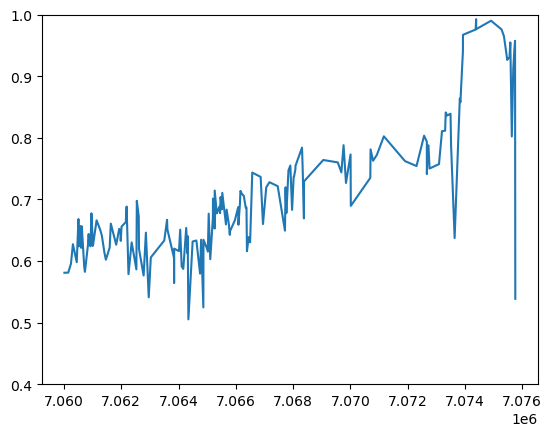

In [298]:
fig, ax = plt.subplots()

ax.plot(sites['POS'], sites['AF'])

ax.set_ylim(0.4, 1.0)

plt.show()

### Do once

In [299]:
# 2. Get _n_ positions of biallelic SNPs sites spanning `Chrom:start-end`
pos_to_test = sites.sample(50).sort_values(by="POS")["POS"].to_list()
print(f"pos_to_test = {list(pos_to_test)}")

pos_to_test = list(pos_to_test)

pos_to_test = [7060446, 7060601, 7060999, 7061323, 7061983, 7062188, 7062364, 7062611, 7062620, 7063502, 7064016, 7064167, 7064269, 7064345, 7064790, 7064868, 7064872, 7065022, 7065025, 7065054, 7065200, 7065204, 7065759, 7065792, 7065968, 7066084, 7066163, 7066348, 7066500, 7066950, 7067840, 7068082, 7068085, 7068313, 7069055, 7069848, 7070698, 7071171, 7072767, 7073311, 7073518, 7073823, 7073932, 7073933, 7074393, 7074395, 7075281, 7075365, 7075639, 7075752]


### Now run this

In [13]:
pos_to_test = [
    7060446, 7060601, 7060999, 7061323, 7061983, 7062188, 7062364, 7062611, 7062620, 7063502, 7064016, 7064167, 7064269, 7064345, 7064790,
    7064868, 7064872, 7065022, 7065025, 7065054, 7065200, 7065204, 7065759, 7065792, 7065968, 7066084, 7066163, 7066348, 7066500, 7066950,
    7067840, 7068082, 7068085, 7068313, 7069055, 7069848, 7070698, 7071171, 7072767, 7073311, 7073518, 7073823, 7073932, 7073933, 7074393,
    7074395, 7075281, 7075365, 7075639, 7075752]

In [14]:
# 2. For each position, get the pileup and extract which allele is found in each read name
results = extract_bases_at_positions(bam_path, chrom, pos_to_test)
results

,read_name,pos,base
0,a9a0ada9-7b72-4e2e-af7b-361a482bf586,7060446,C
1,4541585f-4fbc-4d78-904c-396b575273db,7060446,C
2,9781ac28-f99e-4765-8356-4e1e330e1472,7060446,T
3,037bcd4e-97f1-4267-b8e8-97b7aa863677,7060446,T
4,541f3d4a-e862-4f01-a7d8-2a6bdeb82a55,7060446,T
...,...,...,...
37006,7fe4abf2-7784-4037-b421-1fd3b7f97b02,7075752,C
37007,1909a174-1063-48cb-8b9c-444083e5bb11,7075752,C
37008,fa8e8dc4-3b7c-4e91-8695-9a1ad2cee8e7,7075752,C
37009,97b624ea-4ccd-425a-9c71-73d4e168c300,7075752,C


In [15]:
# 3. Reconstruct each read haplotype
per_read_haplotype = reconstruct_haplotypes(results, pos_to_test)

In [16]:
# Crop matrix
haplo_array = convert_matrix(per_read_haplotype)
#haplo_array

In [17]:
sorted_mat = sort_matrix(haplo_array[:,11:], max_nan=4, empty_first=False)
print(len(sorted_mat))

66


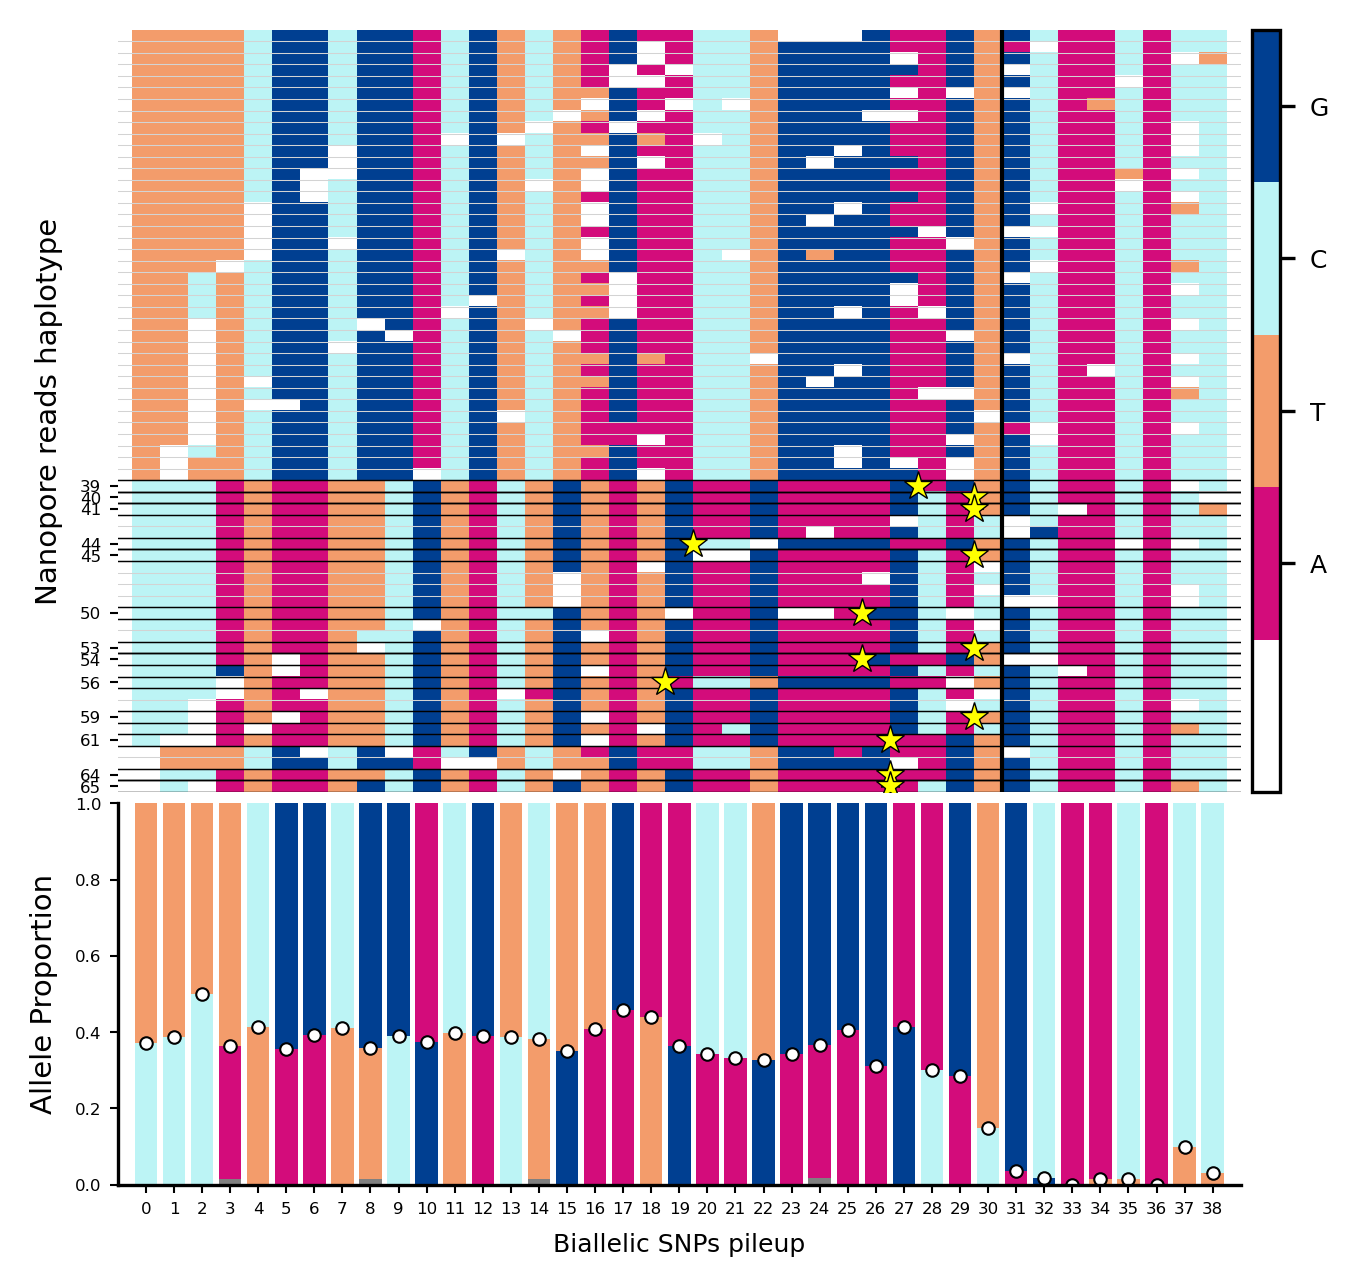

In [19]:
plot_figure(
    sorted_mat,
    tick_to_show = [39,40,41,44, 45, 50, 53, 54, 56, 59, 61, 64, 65],
    stars = [(39, 27.5), (40, 29.5), (41, 29.5), (44, 19.5), (45, 29.5), (56, 18.5), (50, 25.5), (53, 29.5), (54, 25.5), (59, 29.5), (61, 26.5), (64, 26.5), (65, 26.5), ],
    loh_boundary = 30.5,
    star_params={'ms':7, 'mew':0.33}
)

### Chrom 1 right boundary

In [20]:
chrom = "Chrom_1"
start = 7328500
end = 7342000
sites = extract_biallelic_snps(vcf_path, chrom, start, end)
print(f"Found {len(sites)} in region with shifting AF")

Found 181 in region with shifting AF


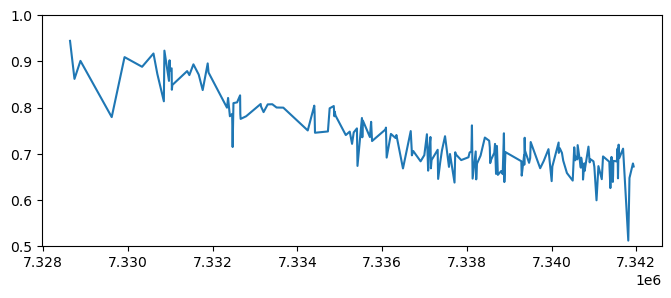

In [401]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(sites['POS'], sites['AF'])

ax.set_ylim(0.5, 1.0)

plt.show()

### run once

In [21]:
# 2. Get _n_ positions of biallelic SNPs sites spanning `Chrom:start-end`
pos_to_test = sites.sample(50).sort_values(by="POS")["POS"].to_list()
print(f"pos_to_test = {list(pos_to_test)}")

pos_to_test = list(pos_to_test)

pos_to_test = [7328737, 7330333, 7330693, 7331036, 7331449, 7332363, 7332647, 7332789, 7333133, 7333140, 7333201, 7333299, 7333508, 7334720, 7334761, 7334858, 7335418, 7336090, 7336492, 7336675, 7336996, 7337057, 7337086, 7337311, 7337671, 7337735, 7337867, 7338038, 7338066, 7338107, 7338120, 7338131, 7338136, 7338665, 7338710, 7338811, 7338875, 7339365, 7339373, 7339428, 7339469, 7339927, 7340002, 7340166, 7340690, 7340780, 7341106, 7341541, 7341599, 7341811]


### then rerun

In [22]:
pos_to_test = [7328737, 7329919, 7330602, 7330693, 7330968, 7331449, 7331670, 7331764, 7332647, 7333299, 7334244, 7334398, 7334415, 7334879, 7335290, 7335418, 7335762, 7336090, 7336107, 7336207, 7336317, 7336996, 7337057, 7337372, 7338066, 7338120, 7338209, 7338551, 7338572, 7338710, 7338811, 7338885, 7338911, 7339295, 7339469, 7339815, 7340362, 7340499, 7340535, 7340742, 7340772, 7341388, 7341419, 7341446, 7341558, 7341568, 7341599, 7341811, 7341839, 7341921]

In [23]:
# 2. For each position, get the pileup and extract which allele is found in each read name
results = extract_bases_at_positions(bam_path, chrom, pos_to_test)
results

,read_name,pos,base
0,fb348cbf-72ff-4eb8-9ef0-8121bf634d20,7328737,G
1,b1a9ea61-ed0e-4d48-8e4b-0e3f12fca902,7328737,G
2,46c35181-8869-4de9-938c-0ba9a7f32a9c,7328737,G
3,c7271da9-977e-4df9-8dbb-192abf15ab6f,7328737,T
4,43234bc3-c2fe-4c4c-ab51-73e35ab7c705,7328737,G
...,...,...,...
34969,1cbc3449-a9d8-4656-a97f-f998222907bf,7341921,T
34970,0f180e65-bedd-4d06-b8e4-6c31f163d4e3,7341921,T
34971,09673586-482d-4599-ad13-043fc8ef7ded,7341921,C
34972,1a28ac52-94fb-4fbc-ae44-89e3449403cb,7341921,T


In [24]:
# 3. Reconstruct each read haplotype
per_read_haplotype = reconstruct_haplotypes(results, pos_to_test)

In [25]:
# Crop matrix
haplo_array = convert_matrix(per_read_haplotype)

In [26]:
sorted_mat = sort_matrix(haplo_array, max_nan=6, empty_first=False, start_reverse=False, sort_agglo=True)
print(len(sorted_mat))

78


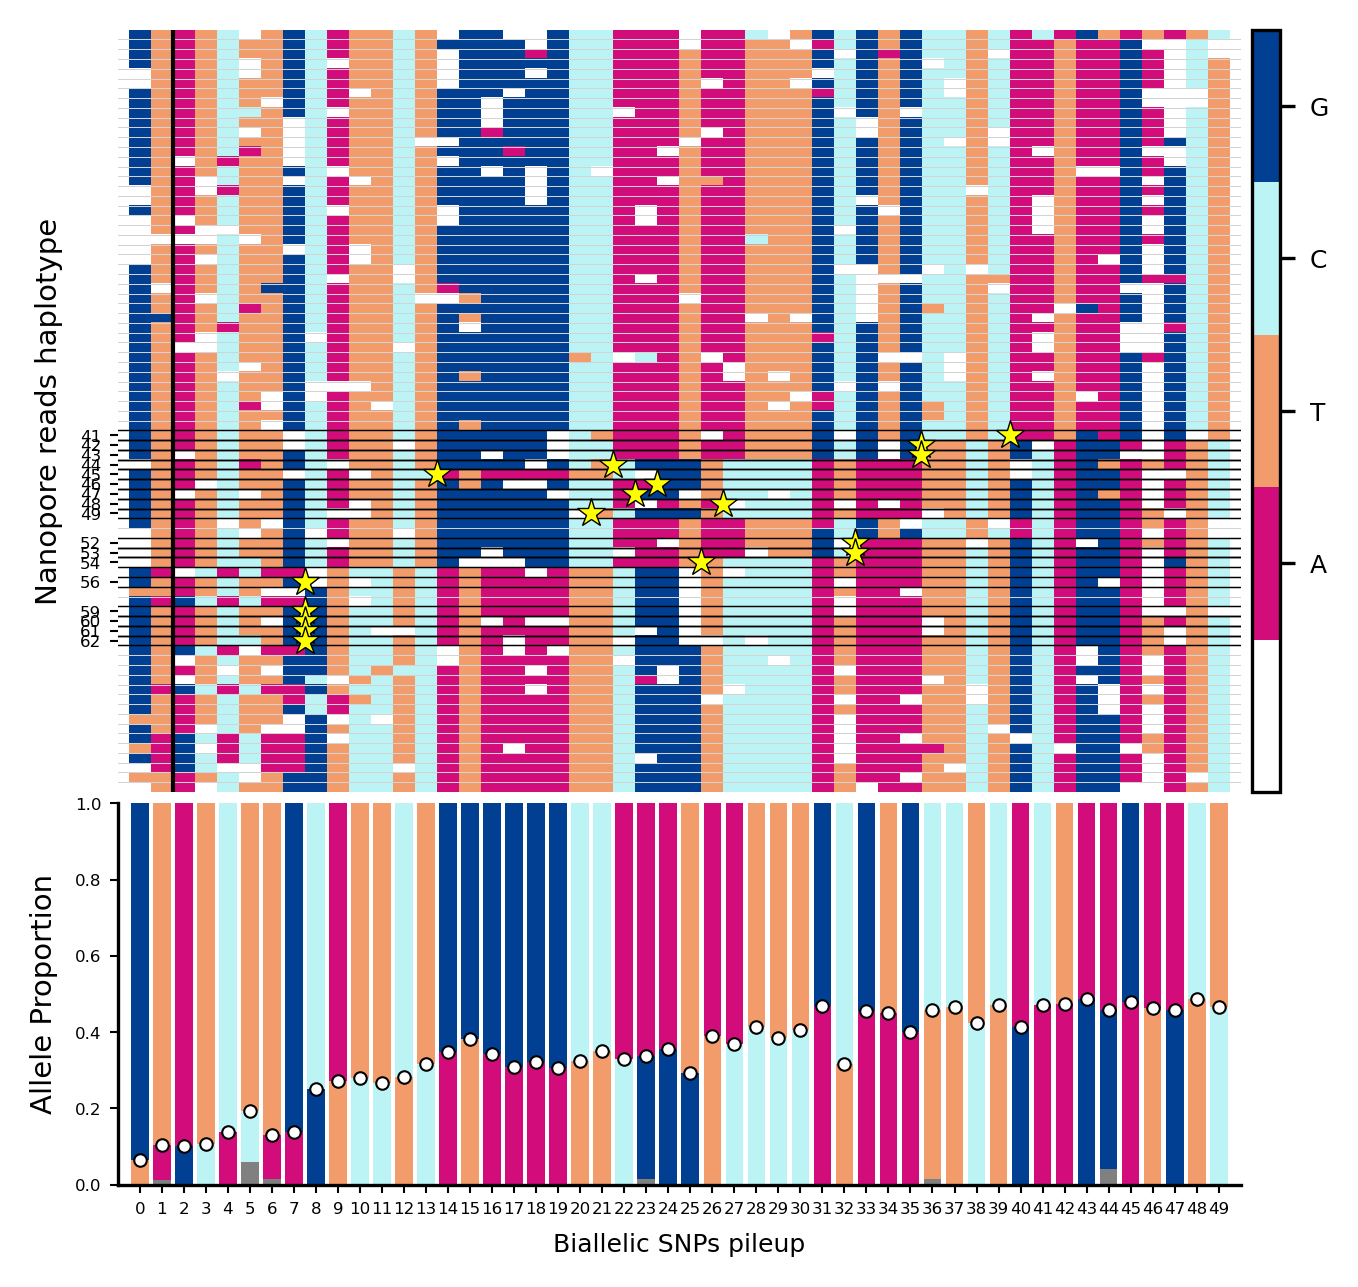

In [27]:
plot_figure(
    sorted_mat,
    tick_to_show = [41, 42, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 56, 59, 60, 61, 62],
    stars = [
        (41, 39.5), (42, 35.5), (43, 35.5), (44, 21.5), (45, 13.5), (46, 23.5), (47, 22.5), (48, 26.5), (49,20.5), (52, 32.5), (53, 32.5), (54, 25.5),
        (56, 7.5), (59, 7.5), (60, 7.5), (61, 7.5), (62, 7.5), 
    ],
    loh_boundary = 1.5,
    star_params={'ms':7, 'mew':0.33}
)

### Chrom 4 left boundary

In [28]:
chrom = "Chrom_4"
start = 4910000
end = 4940000
sites = extract_biallelic_snps(vcf_path, chrom, start, end)
print(f"Found {len(sites)} in region with shifting AF")

Found 251 in region with shifting AF


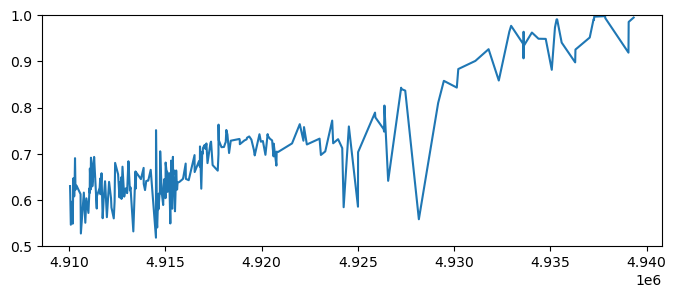

In [36]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(sites['POS'], sites['AF'])

ax.set_ylim(0.5, 1.0)

plt.show()

### run once

In [446]:
# 2. Get _n_ positions of biallelic SNPs sites spanning `Chrom:start-end`
pos_to_test = sites.sample(50).sort_values(by="POS")["POS"].to_list()
print(f"pos_to_test = {list(pos_to_test)}")

pos_to_test = list(pos_to_test)

pos_to_test = [4910091, 4910178, 4910334, 4910386, 4910613, 4910844, 4911137, 4911194, 4911301, 4911686, 4911745, 4911964, 4912644, 4912718, 4913014, 4913083, 4913733, 4914112, 4914644, 4914716, 4914733, 4914871, 4914888, 4914967, 4915130, 4915199, 4915279, 4915299, 4915317, 4915387, 4915401, 4915564, 4915732, 4915932, 4917046, 4917376, 4919108, 4919643, 4920322, 4920431, 4923668, 4924263, 4926364, 4927462, 4928170, 4930218, 4931105, 4935240, 4937842, 4939069]


### then rerun

In [34]:
pos_to_test = [4910091, 4910178, 4910334, 4910386, 4910613, 4910844, 4911137, 4911194, 4911301, 4911686, 4911745, 4911964, 4912644, 4912718, 4913014, 4913083, 4913733, 4914112, 4914644, 4914716, 4914733, 4914871, 4914888, 4914967, 4915130, 4915199, 4915279, 4915299, 4915317, 4915387, 4915401, 4915564, 4915732, 4915932, 4917046, 4917376, 4919108, 4919643, 4920322, 4920431, 4923668, 4924263, 4926364, 4927462, 4928170, 4930218, 4931105, 4935240, 4937842, 4939069]

In [30]:
# 2. For each position, get the pileup and extract which allele is found in each read name
results = extract_bases_at_positions(bam_path, chrom, pos_to_test)
results

,read_name,pos,base
0,40a32579-135b-4fc6-a429-32917fb4f958,4910091,A
1,e9873273-9cc2-4bc9-9783-18381677e1e6,4910091,G
2,24cfa1df-9b07-4209-8496-baa1fd0df3ce,4910091,A
3,26b8f41d-ae2a-4d14-af67-27e585b4620a,4910091,G
4,ee5a3fbb-a6d7-438f-bae6-991637a27f61,4910091,A
...,...,...,...
37139,9f4fe2a5-3f15-43f2-ad8a-ea400340a707,4939069,C
37140,a7b7885d-1e7e-4b33-8aea-fab505b8ba17,4939069,C
37141,50a6e9e4-a6be-48b0-9d9a-114ed15b7b27,4939069,C
37142,d8881628-4075-49f1-b258-a27ad35958fc,4939069,C


In [31]:
# 3. Reconstruct each read haplotype
per_read_haplotype = reconstruct_haplotypes(results, pos_to_test)

In [32]:
# Crop matrix
haplo_array = convert_matrix(per_read_haplotype)
#haplo_array

In [37]:
sorted_mat = sort_matrix(haplo_array, max_nan=7, empty_first=False, start_reverse=False, sort_agglo=True)
print(len(sorted_mat))

67


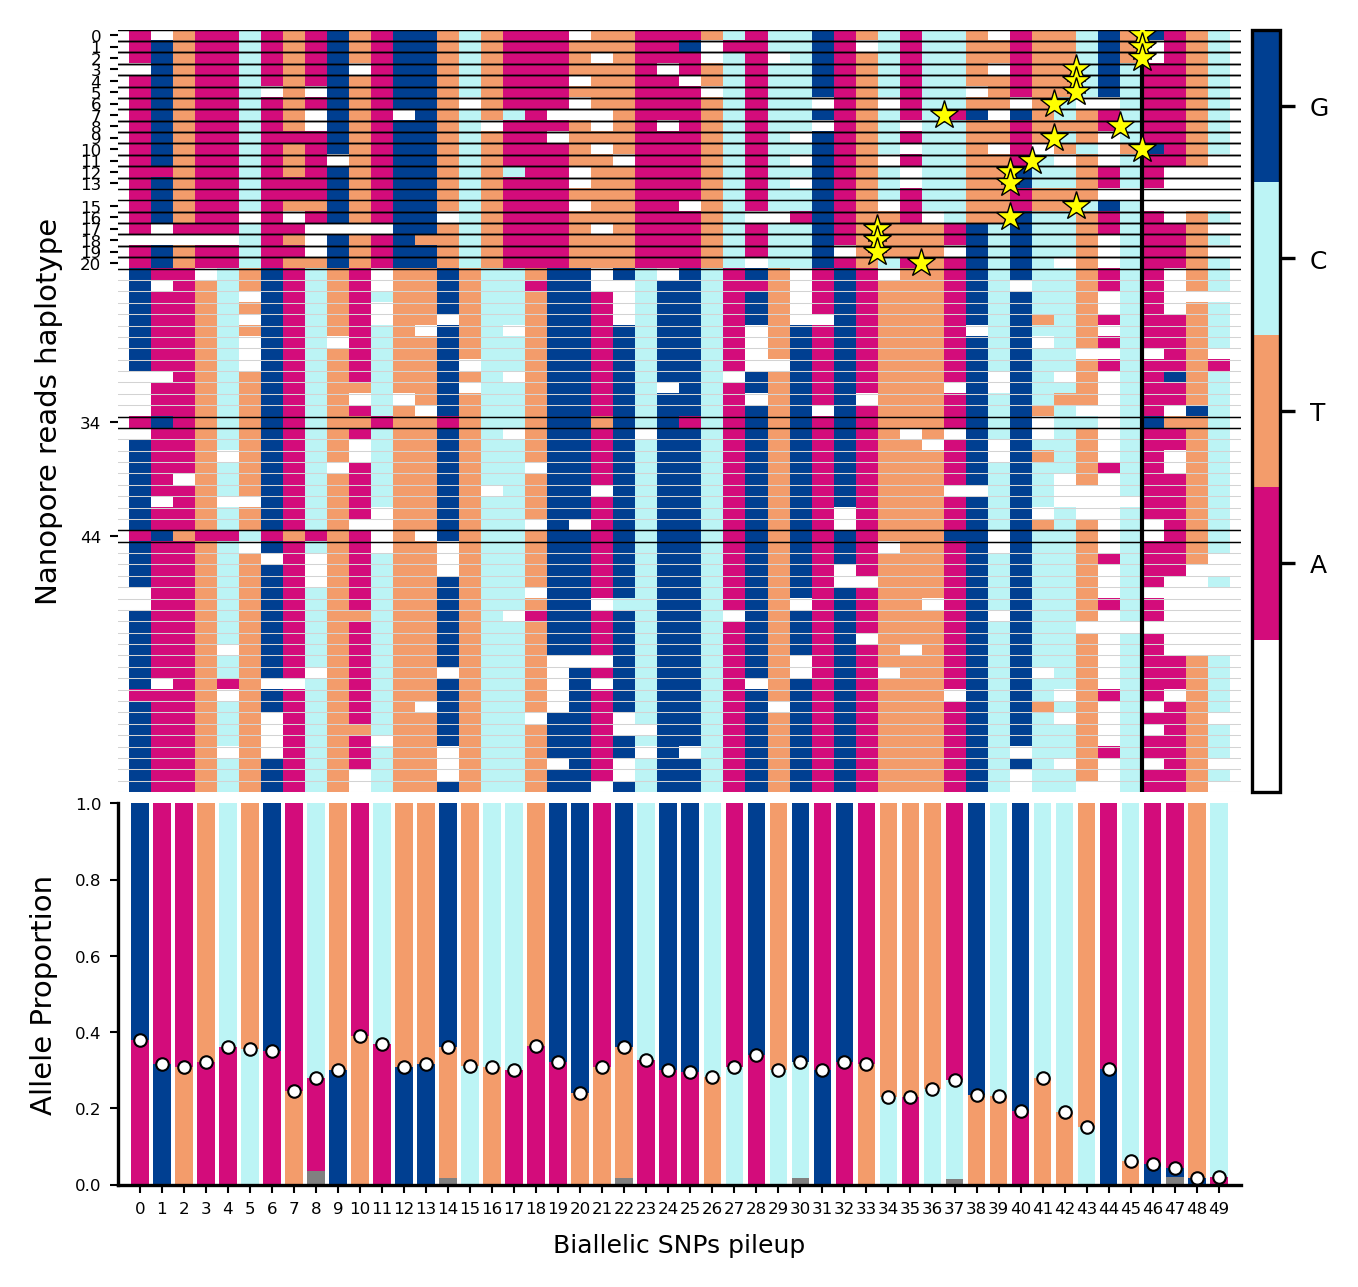

In [39]:
plot_figure(
    sorted_mat,
    tick_to_show = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16, 17, 18,19,20,34,44],
    stars = [
        (0,45.5),(1,45.5),(2,45.5),(10,45.5),(3,42.5),(4,42.5),(5,42.5),(6,41.5),(7,36.5),(9,41.5),(8,44.5),
        (11, 40.5),(12, 39.5),(13, 39.5),(15,42.5),(16, 39.5), (17, 33.5), (18, 33.5), (19, 33.5), (20, 35.5), #(34, 1.5), (44, 8.5), 
    ],
    loh_boundary = 45.5,
    star_params={'ms':7, 'mew':0.33}
)

### Chrom 4 right boundary

In [40]:
chrom = "Chrom_4"
start = 4967000
end = 4985000
sites = extract_biallelic_snps(vcf_path, chrom, start, end)
print(f"Found {len(sites)} in region with shifting AF")

Found 130 in region with shifting AF


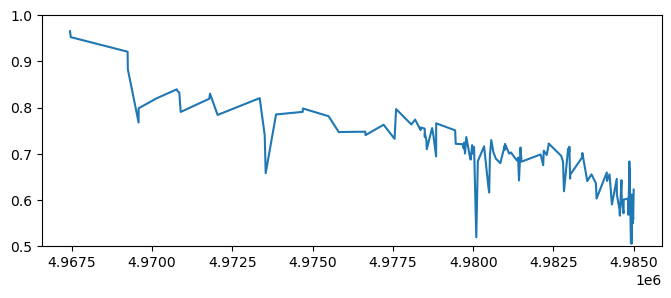

In [41]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(sites['POS'], sites['AF'])

ax.set_ylim(0.5, 1.0)

plt.show()

### run once

In [496]:
# 2. Get _n_ positions of biallelic SNPs sites spanning `Chrom:start-end`
pos_to_test = sites.sample(50).sort_values(by="POS")["POS"].to_list()
print(f"pos_to_test = {list(pos_to_test)}")

pos_to_test = list(pos_to_test)

pos_to_test = [4967442, 4967465, 4969243, 4969579, 4970141, 4970767, 4970786, 4970890, 4972039, 4975812, 4976646, 4978720, 4978760, 4979455, 4979666, 4979705, 4979723, 4979922, 4979967, 4980027, 4980096, 4980474, 4980498, 4980520, 4980562, 4980844, 4980987, 4980990, 4981176, 4981426, 4981474, 4981505, 4982096, 4982289, 4982348, 4982743, 4983019, 4983822, 4984474, 4984622, 4984628, 4984830, 4984836, 4984866, 4984913, 4984914, 4984927, 4984935, 4984937, 4984970]


### then rerun

In [42]:
pos_to_test = [4967442, 4967465, 4969243, 4969579, 4970141, 4970767, 4970786, 4970890, 4972039, 4975812, 4976646, 4978720, 4978760, 4979455, 4979666, 4979705, 4979723, 4979922, 4979967, 4980027, 4980096, 4980474, 4980498, 4980520, 4980562, 4980844, 4980987, 4980990, 4981176, 4981426, 4981474, 4981505, 4982096, 4982289, 4982348, 4982743, 4983019, 4983822, 4984474, 4984622, 4984628, 4984830, 4984836, 4984866, 4984913, 4984914, 4984927, 4984935, 4984937, 4984970]

In [43]:
# 2. For each position, get the pileup and extract which allele is found in each read name
results = extract_bases_at_positions(bam_path, chrom, pos_to_test)
#results

In [44]:
# 3. Reconstruct each read haplotype
per_read_haplotype = reconstruct_haplotypes(results, pos_to_test)

In [45]:
# Crop matrix
haplo_array = convert_matrix(per_read_haplotype)
#haplo_array

In [46]:
sorted_mat = sort_matrix(haplo_array, max_nan=6, empty_first=False, start_reverse=False, sort_agglo=True)
print(len(sorted_mat))

73


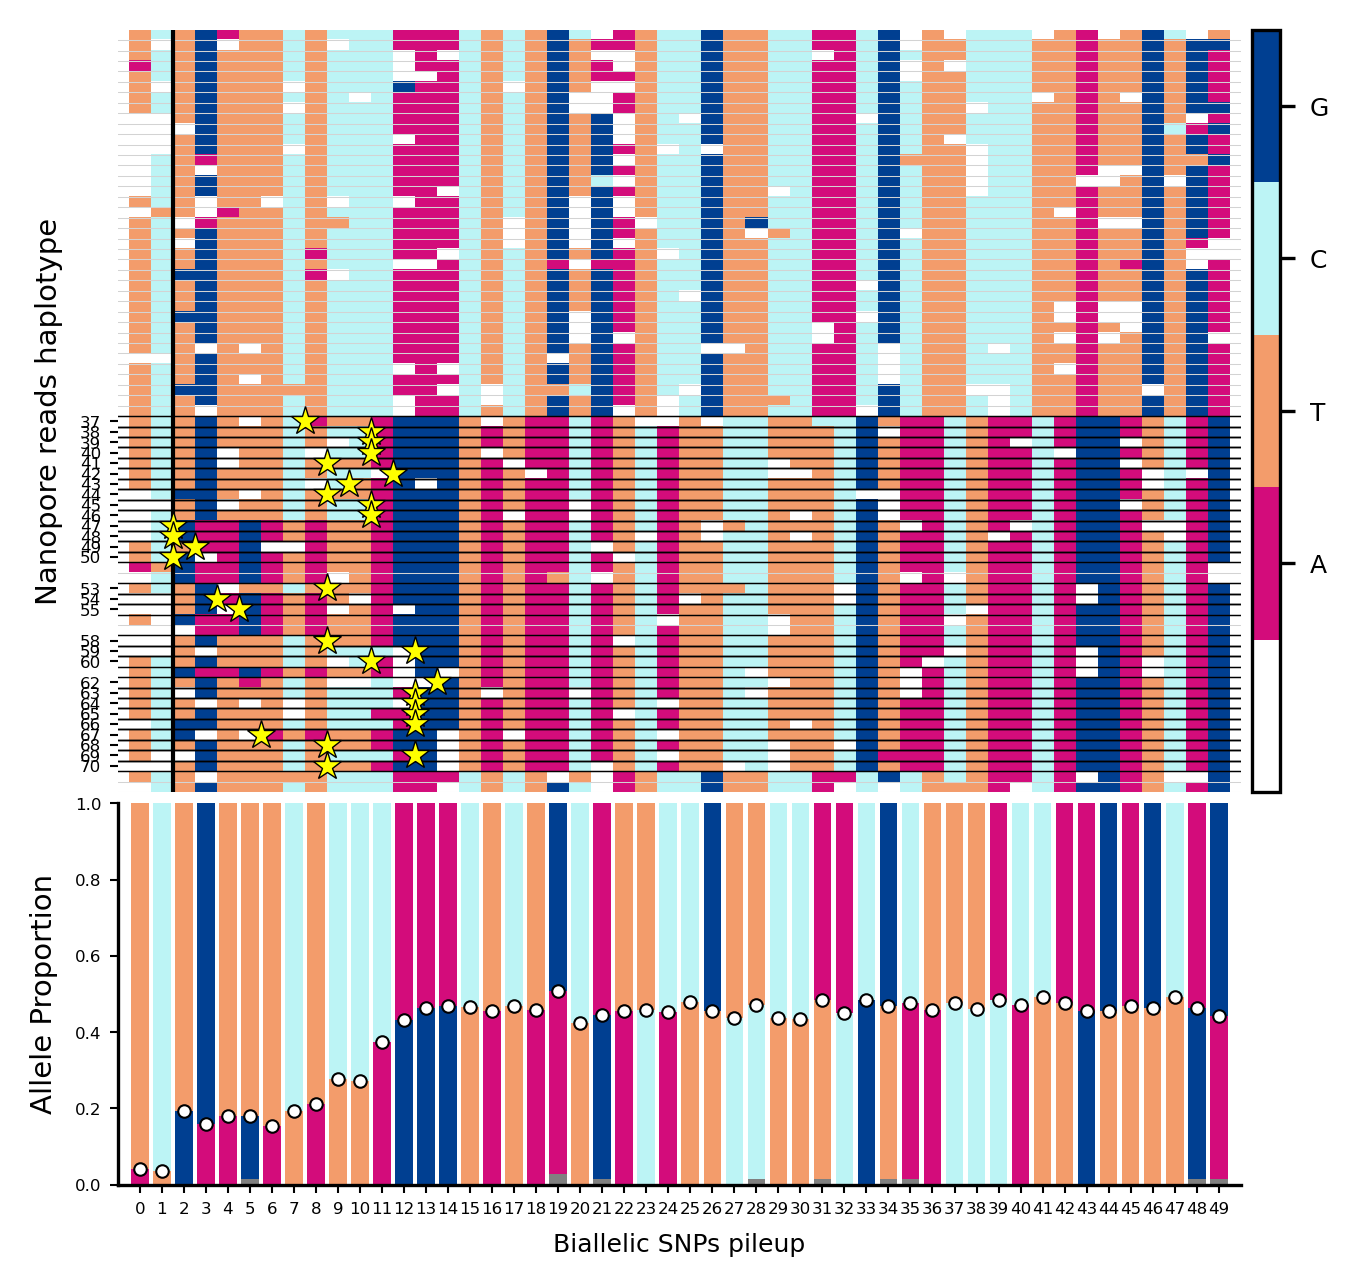

In [48]:
plot_figure(
    sorted_mat,
    tick_to_show = [37,38,39,40,41,42,43,44,45,46,47,48,49,50,53,54,55,59,60,62,63,64,65,66,67,68,69,70,58],
    stars = [
        (37, 7.5), (38, 10.5), (39, 10.5), (40, 10.5), (41, 8.5), (42, 11.5), (43, 9.5), (44, 8.5), (45, 10.5), (46, 10.5), (47, 1.5),
        (48, 1.5), (49, 2.5), (50, 1.5), (53, 8.5), (54, 3.5), (55, 4.5), (59,12.5), (60, 10.5), (62, 13.5), (63, 12.5), (64, 12.5), (65, 12.5),
        (66, 12.5), (69, 12.5), (68, 8.5), (67, 5.5), (70, 8.5), (58,8.5)
    ],
    loh_boundary = 1.5,
    star_params={'ms':7, 'mew':0.33}
)